In [6]:
import numpy as np
def npz_load(npzfile):
    with np.load(npzfile) as file:
        data = file['x']
        labels = file['y']
        sampling_rate = file['fs']
    return data,labels,sampling_rate

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
def load_n_npzfiles(npzfiles):
    data = []
    labels = []
    fs = None
    for npz_file in npzfiles:
        t_data,t_labels,sampling_rate = npz_load(npz_file)
        if fs is None:
            fs = sampling_rate
        elif fs!= sampling_rate:
            raise Exception("Mismatch in Sampling Rate")
        data.append(t_data)
        labels.append(t_labels)
    data = np.vstack(data)
    labels = np.hstack(labels)
    return data,labels


In [13]:
import os
path="/content/drive/MyDrive/project/DATA"
files = os.listdir(path)
fs = []
for i in files:
    fs.append(os.path.join(path,i))
X,Y = load_n_npzfiles(fs[0:len(fs)-9])
X = X[:15000]
Y = Y[:15000]
print(X.shape)
X = X.reshape((X.shape[0], X.shape[1], 1))

(15000, 3000, 1)


In [12]:
Y.shape

(928,)

In [9]:
print(fs)

['/content/drive/MyDrive/project/DATA/SC4252E0.npz', '/content/drive/MyDrive/project/DATA/SC4151E0.npz', '/content/drive/MyDrive/project/DATA/SC4281G0.npz', '/content/drive/MyDrive/project/DATA/SC4122E0.npz', '/content/drive/MyDrive/project/DATA/SC4161E0.npz', '/content/drive/MyDrive/project/DATA/SC4071E0.npz', '/content/drive/MyDrive/project/DATA/SC4072E0.npz', '/content/drive/MyDrive/project/DATA/SC4262F0.npz', '/content/drive/MyDrive/project/DATA/SC4022E0.npz', '/content/drive/MyDrive/project/DATA/SC4182E0.npz', '/content/drive/MyDrive/project/DATA/SC4141E0.npz', '/content/drive/MyDrive/project/DATA/SC4052E0.npz', '/content/drive/MyDrive/project/DATA/SC4212E0.npz', '/content/drive/MyDrive/project/DATA/SC4222E0.npz', '/content/drive/MyDrive/project/DATA/SC4091E0.npz', '/content/drive/MyDrive/project/DATA/SC4191E0.npz', '/content/drive/MyDrive/project/DATA/SC4042E0.npz', '/content/drive/MyDrive/project/DATA/SC4001E0.npz', '/content/drive/MyDrive/project/DATA/SC4211E0.npz', '/content/d

In [ ]:
from keras import models
onlycnn = models.load_model('/content/drive/MyDrive/project/CNN.h5')
cnnlstm = models.load_model('/content/drive/MyDrive/project/CNNLSTM.h5')
lstm = models.load_model('/content/drive/MyDrive/project/LSTM.h5')

In [ ]:
def compare(y_prob,y_prob1):
  actual_pred = []
  for i in range(len(y_prob1)):
    l=[]
    for j in range(5):
        l.append((y_prob[i][j]+y_prob1[i][j])/2)
    maxval = max(l)
    idx = l.index(maxval)
    actual_pred.append(idx)
  return actual_pred


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import keras
from tensorflow.keras.layers import Bidirectional #we will be needing this layer
from sklearn.model_selection import StratifiedKFold
import time
import gc
from datetime import datetime as dt

In [ ]:
nsplits = 5
k=0
cv_results=[]
sk = StratifiedKFold(n_splits=nsplits)
for train_idx,test_idx in sk.split(X,Y):
  X_train,X_test = X[train_idx],X[test_idx]
  y_train,y_test= Y[train_idx],Y[test_idx]
  X_c_train,X_c_test = X_train,X_test
  y_c_train,y_c_test = y_train,y_test
  X_train = np.reshape(X_train, (-1, X_train.shape[1], 1))
  X_test = np.reshape(X_test, (-1, X_test.shape[1], 1))
# Applyingstandardization
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train.reshape((X_train.shape[0], -1))).reshape(X_train.shape)
  X_test = scaler.transform(X_test.reshape((X_test.shape[0], -1))).reshape(X_test.shape)
  onlycnn.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
# Training the model
  history = onlycnn.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))
# Evaluating the model on test data
  y_probcnn = onlycnn.predict(X_test)
  y_pred1 = y_probcnn.argmax(axis=-1)
  loss, accuracy = onlycnn.evaluate(X_test, y_test)
  print(f'Test Loss: {loss:.4f}')
  print(f'Test Accuracy: {accuracy:.4f}')
  begin_time_loop = dt.now()
  print('Current time: {}'.format(str(begin_time_loop)))
  cnnlstm.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
  cnnlstm.fit(X_c_train, y_c_train,
                    batch_size=100,
                    epochs=5) # 24
    #getting feature vectors
  layer_name = 'concat'
  intermediate_layer_model = keras.Model(inputs=cnnlstm.input,
                                  outputs=cnnlstm.get_layer(layer_name).output)
  intermediate_output_train = intermediate_layer_model.predict(X_c_train)
  intermediate_output_test = intermediate_layer_model.predict(X_c_test)
  X_train_lstm = intermediate_output_train
  X_test_lstm = intermediate_output_test
  a = np.zeros((1, 2688))
  X_train_lstm = np.insert(X_train_lstm, 0, a, axis=0)
  X_train_lstm = np.insert(X_train_lstm, 0, a, axis=0)
  X_train_lstm = np.insert(X_train_lstm, -1, a, axis=0)
  X_train_lstm = np.insert(X_train_lstm, -1, a, axis=0)
  X_test_lstm = np.insert(X_test_lstm, 0, a, axis=0)
  X_test_lstm = np.insert(X_test_lstm, 0, a, axis=0)
  X_test_lstm = np.insert(X_test_lstm, -1, a, axis=0)
  X_test_lstm = np.insert(X_test_lstm, -1, a, axis=0)
  num_train_clips = len(X_train_lstm) - 4
  num_test_clips = len(X_test_lstm) - 4
  clip_length = 2688
  X_train_lstm2 = np.empty((num_train_clips, 5, clip_length))  # Initialize empty array for training clips
  for i in range(num_train_clips):
      j = i + 2
      X_train_lstm2[i] = np.array([X_train_lstm[j-2], X_train_lstm[j-1], X_train_lstm[j], X_train_lstm[j+1], X_train_lstm[j+2]])

  X_test_lstm2 = np.empty((num_test_clips, 5, clip_length))  # Initialize empty array for testing clips
  for i in range(num_test_clips):
      j = i + 2
      X_test_lstm2[i] = np.array([X_test_lstm[j-2], X_test_lstm[j-1], X_test_lstm[j], X_test_lstm[j+1], X_test_lstm[j+2]])
    #LSTM
  lstm.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
  lstm.fit(X_train_lstm2, y_c_train,
                      batch_size=100,
                      epochs=5, validation_data=(X_test_lstm2, y_test)) #
  test_scores = lstm.evaluate(X_test_lstm2, y_c_test, verbose=0)
  print('Test accuracy:', test_scores[1])
  y_prob = lstm.predict(X_test_lstm2) ##
  y_pred = y_prob.argmax(axis=-1)
  elapsed = dt.now() - begin_time_loop
  final_pred = compare(y_probcnn,y_prob)
  print('Fold {} took {}'.format(str(k), str(elapsed)))
  fold_result = {'fold': k, 'time': elapsed,'y_test': y_test, 'y_pred': final_pred,'y_cnn':y_pred1,'y_lstm':y_pred ,'y_prob': y_prob,
                'Final_accuracy':accuracy_score(final_pred,y_test),'cnn_accuracy':accuracy,'lstm_accuracy': test_scores[1]}
  del X_test_lstm2, X_train_lstm2, intermediate_output_train, intermediate_output_test
  gc.collect()
  k+=1
  print("Final prediction:",accuracy_score(final_pred,y_test))
  cv_results.append(fold_result)


Epoch 1/10
375/375 [==============================] - 29s 42ms/step - loss: 0.3934 - accuracy: 0.8750 - val_loss: 0.0803 - val_accuracy: 0.9837
Epoch 2/10
375/375 [==============================] - 13s 36ms/step - loss: 0.2878 - accuracy: 0.8990 - val_loss: 0.0901 - val_accuracy: 0.9727
Epoch 3/10
375/375 [==============================] - 14s 37ms/step - loss: 0.2552 - accuracy: 0.9149 - val_loss: 0.1240 - val_accuracy: 0.9577
Epoch 4/10
375/375 [==============================] - 14s 37ms/step - loss: 0.2266 - accuracy: 0.9212 - val_loss: 0.1249 - val_accuracy: 0.9560
Epoch 5/10
375/375 [==============================] - 14s 37ms/step - loss: 0.2061 - accuracy: 0.9298 - val_loss: 0.1551 - val_accuracy: 0.9393
Epoch 6/10
375/375 [==============================] - 14s 37ms/step - loss: 0.1943 - accuracy: 0.9311 - val_loss: 0.1648 - val_accuracy: 0.9377
Epoch 7/10
375/375 [==============================] - 13s 35ms/step - loss: 0.2085 - accuracy: 0.9303 - val_loss: 0.7563 - val_accuracy:

Epoch 1/10
375/375 [==============================] - 20s 38ms/step - loss: 0.2281 - accuracy: 0.9223 - val_loss: 0.0252 - val_accuracy: 0.9960
Epoch 2/10
375/375 [==============================] - 14s 36ms/step - loss: 0.1889 - accuracy: 0.9334 - val_loss: 0.0269 - val_accuracy: 0.9967
Epoch 3/10
375/375 [==============================] - 14s 37ms/step - loss: 0.1560 - accuracy: 0.9458 - val_loss: 0.0246 - val_accuracy: 0.9953
Epoch 4/10
375/375 [==============================] - 13s 36ms/step - loss: 0.1383 - accuracy: 0.9534 - val_loss: 0.0311 - val_accuracy: 0.9913
Epoch 5/10
375/375 [==============================] - 13s 36ms/step - loss: 0.1197 - accuracy: 0.9567 - val_loss: 0.0328 - val_accuracy: 0.9907
Epoch 6/10
375/375 [==============================] - 13s 35ms/step - loss: 0.1129 - accuracy: 0.9601 - val_loss: 0.0365 - val_accuracy: 0.9910
Epoch 7/10
375/375 [==============================] - 13s 36ms/step - loss: 0.1428 - accuracy: 0.9512 - val_loss: 0.1151 - val_accuracy:

Epoch 1/10
375/375 [==============================] - 21s 38ms/step - loss: 0.1601 - accuracy: 0.9461 - val_loss: 0.0692 - val_accuracy: 0.9763
Epoch 2/10
375/375 [==============================] - 14s 37ms/step - loss: 0.1238 - accuracy: 0.9569 - val_loss: 0.0051 - val_accuracy: 0.9993
Epoch 3/10
375/375 [==============================] - 13s 36ms/step - loss: 0.1038 - accuracy: 0.9656 - val_loss: 0.0660 - val_accuracy: 0.9777
Epoch 4/10
375/375 [==============================] - 14s 37ms/step - loss: 0.0954 - accuracy: 0.9670 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 5/10
375/375 [==============================] - 14s 37ms/step - loss: 0.1006 - accuracy: 0.9669 - val_loss: 0.0265 - val_accuracy: 0.9920
Epoch 6/10
375/375 [==============================] - 14s 37ms/step - loss: 0.0939 - accuracy: 0.9680 - val_loss: 0.0322 - val_accuracy: 0.9887
Epoch 7/10
375/375 [==============================] - 14s 37ms/step - loss: 0.0905 - accuracy: 0.9673 - val_loss: 0.0115 - val_accuracy:

Epoch 1/10
375/375 [==============================] - 20s 37ms/step - loss: 0.1093 - accuracy: 0.9617 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 2/10
375/375 [==============================] - 14s 36ms/step - loss: 0.0943 - accuracy: 0.9694 - val_loss: 0.0027 - val_accuracy: 0.9997
Epoch 3/10
375/375 [==============================] - 14s 37ms/step - loss: 0.0902 - accuracy: 0.9690 - val_loss: 0.0045 - val_accuracy: 0.9993
Epoch 4/10
375/375 [==============================] - 14s 37ms/step - loss: 0.0824 - accuracy: 0.9710 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 5/10
375/375 [==============================] - 13s 36ms/step - loss: 0.0829 - accuracy: 0.9716 - val_loss: 0.0037 - val_accuracy: 0.9993
Epoch 6/10
375/375 [==============================] - 13s 36ms/step - loss: 0.0888 - accuracy: 0.9697 - val_loss: 0.0060 - val_accuracy: 0.9987
Epoch 7/10
375/375 [==============================] - 14s 37ms/step - loss: 0.0757 - accuracy: 0.9760 - val_loss: 0.0065 - val_accuracy:

Epoch 1/10
375/375 [==============================] - 21s 38ms/step - loss: 0.0732 - accuracy: 0.9747 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2/10
375/375 [==============================] - 13s 36ms/step - loss: 0.0725 - accuracy: 0.9759 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 3/10
375/375 [==============================] - 14s 36ms/step - loss: 0.0703 - accuracy: 0.9757 - val_loss: 0.0037 - val_accuracy: 0.9997
Epoch 4/10
375/375 [==============================] - 14s 37ms/step - loss: 0.0615 - accuracy: 0.9785 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 5/10
375/375 [==============================] - 13s 36ms/step - loss: 0.0657 - accuracy: 0.9787 - val_loss: 0.0043 - val_accuracy: 0.9997
Epoch 6/10
375/375 [==============================] - 14s 37ms/step - loss: 0.0631 - accuracy: 0.9793 - val_loss: 0.0042 - val_accuracy: 0.9990
Epoch 7/10
375/375 [==============================] - 13s 36ms/step - loss: 0.0571 - accuracy: 0.9811 - val_loss: 0.0221 - val_accuracy:

In [ ]:
from sklearn.metrics import classification_report
y_pred=[]
y_test=[]
for i in cv_results:
  y_pred.extend(i['y_cnn'])
  y_test.extend(i['y_test'])


print(classification_report(y_test,y_pred, digits=4) )

              precision    recall  f1-score   support

           0     0.9524    0.9882    0.9700      2876
           1     0.9398    0.8648    0.9008      1317
           2     0.9873    0.9729    0.9800      6084
           3     0.9684    0.9966    0.9823      2061
           4     0.9475    0.9568    0.9521      2662

    accuracy                         0.9667     15000
   macro avg     0.9591    0.9559    0.9570     15000
weighted avg     0.9668    0.9667    0.9665     15000



In [ ]:
from sklearn.metrics import classification_report
y_pred=[]
y_test=[]
for i in cv_results:
  y_pred.extend(i['y_lstm'])
  y_test.extend(i['y_test'])


print(classification_report(y_test,y_pred, digits=4) )

              precision    recall  f1-score   support

           0     0.7099    0.7291    0.7194      2876
           1     0.2911    0.1587    0.2054      1317
           2     0.8298    0.6083    0.7020      6084
           3     0.7960    0.8389    0.8169      2061
           4     0.4253    0.7502    0.5428      2662

    accuracy                         0.6489     15000
   macro avg     0.6104    0.6170    0.5973     15000
weighted avg     0.6831    0.6489    0.6493     15000



In [ ]:
from sklearn.metrics import classification_report
y_pred=[]
y_test=[]
for i in cv_results:
  y_pred.extend(i['y_pred'])
  y_test.extend(i['y_test'])


print(classification_report(y_test,y_pred, digits=4) )

              precision    recall  f1-score   support

           0     0.9506    0.9899    0.9699      2876
           1     0.9470    0.8269    0.8829      1317
           2     0.9817    0.9610    0.9713      6084
           3     0.9517    0.9937    0.9722      2061
           4     0.9319    0.9617    0.9466      2662

    accuracy                         0.9594     15000
   macro avg     0.9526    0.9466    0.9486     15000
weighted avg     0.9597    0.9594    0.9590     15000



<Axes: title={'center': 'Predicted Hypnogram'}, xlabel='Time (in 30 second epochs)', ylabel='Sleep stage'>

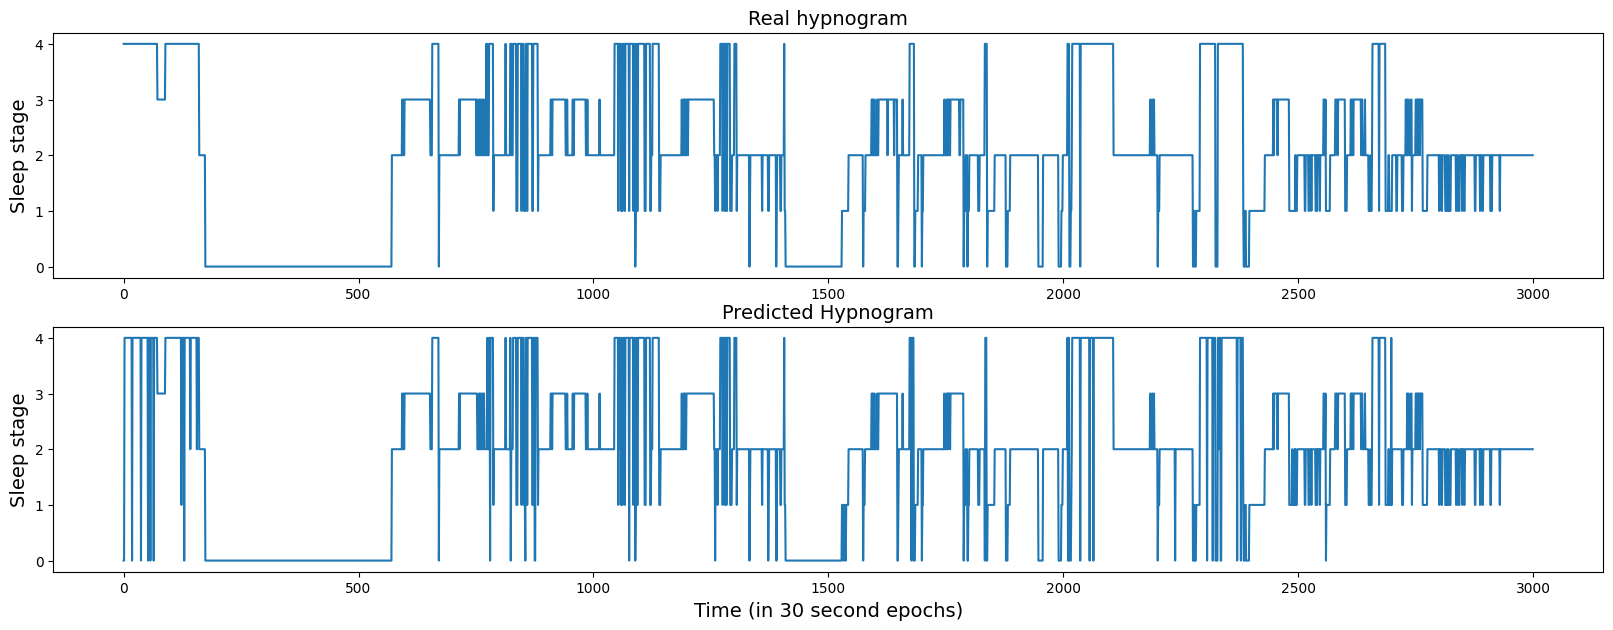

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = cv_results[2]['y_pred']
y_test = cv_results[2]['y_test']

from seaborn import lineplot

fig, axs = plt.subplots(2,1, figsize=(20,7))

axs[0].set_title('Real hypnogram', size = 14)
axs[0].set_ylabel('Sleep stage', fontsize=14)
axs[0].set_yticks([0,1,2,3,4])


axs[1].set_title('Predicted Hypnogram', size = 14)
axs[1].set_ylabel('Sleep stage', fontsize=14)
axs[1].set_yticks([0,1,2,3,4])

axs[1].set_xlabel('Time (in 30 second epochs)', fontsize=14)

sns.lineplot(y_test,ax=axs[0] )
sns.lineplot(y_pred,ax=axs[1])


In [ ]:
acc=[]
for x in cv_results:
  acc.append(x['Final_accuracy'])
print(np.mean(acc))

0.9593999999999999


In [1]:
import numpy as np
import os

class DataLoader:

    def __init__(self, path):
        self.path = path

    def npz_load(self, npzfile):
        with np.load(npzfile) as file:
            data = file['x']
            labels = file['y']
            sampling_rate = file['fs']
        return data, labels, sampling_rate

    def load_n_npzfiles(self, npzfiles):
        data = []
        labels = []
        fs = None
        for npz_file in npzfiles:
            t_data, t_labels, sampling_rate = self.npz_load(npz_file)
            if fs is None:
                fs = sampling_rate
            elif fs != sampling_rate:
                raise Exception("Mismatch in Sampling Rate")
            data.append(t_data)
            labels.append(t_labels)
        data = np.vstack(data)
        labels = np.hstack(labels)
        return data, labels

    def load_data(self):
        files = os.listdir(self.path)
        fs = [os.path.join(self.path, i) for i in files]
        X, Y = self.load_n_npzfiles(fs[0:len(fs) - 9])
        print(X.shape)
        X = X.reshape((X.shape[0], X.shape[1], 1))
        return X, Y



In [5]:
data_loader = DataLoader("/content/drive/MyDrive/Dataset1")

# Load and reshape the data
X, Y = data_loader.load_data()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Dataset1'

In [ ]:

# Example usage:
# Instantiate DataLoader with the path to your data
data_loader = DataLoader("/content/drive/MyDrive/Dataset1")

# Load and reshape the data
X, Y = data_loader.load_data()

# Now X and Y contain the loaded and reshaped data

In [ ]:
class MyModel:


    def __init__(self, nsplits=5):
        self.nsplits = nsplits
        self.cv_results = []
        self.onlycnn = models.load_model('/content/drive/MyDrive/project/CNN.h5')
        self.cnnlstm = models.load_model('/content/drive/MyDrive/project/CNNLSTM.h5')
        self.lstm = models.load_model('/content/drive/MyDrive/project/LSTM.h5')

    def compare(self, y_prob, y_prob1):
        actual_pred = []
        for i in range(len(y_prob1)):
            l = []
            for j in range(5):
                l.append((y_prob[i][j] + y_prob1[i][j]) / 2)
            maxval = max(l)
            idx = l.index(maxval)
            actual_pred.append(idx)
        return actual_pred

    def train_and_evaluate(self, X, Y):
        sk = StratifiedKFold(n_splits=self.nsplits)
        k = 0
        for train_idx, test_idx in sk.split(X, Y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = Y[train_idx], Y[test_idx]
            X_c_train, X_c_test = X_train, X_test
            y_c_train, y_c_test = y_train, y_test
            X_train = np.reshape(X_train, (-1, X_train.shape[1], 1))
            X_test = np.reshape(X_test, (-1, X_test.shape[1], 1))
            # Applying standardization
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train.reshape((X_train.shape[0], -1))).reshape(X_train.shape)
            X_test = scaler.transform(X_test.reshape((X_test.shape[0], -1))).reshape(X_test.shape)
            # Assuming onlycnn, cnnlstm, lstm are defined somewhere
            onlycnn.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
            # Training the model
            history = onlycnn.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))
            # Evaluating the model on test data
            y_probcnn = onlycnn.predict(X_test)
            y_pred1 = y_probcnn.argmax(axis=-1)
            loss, accuracy = onlycnn.evaluate(X_test, y_test)
            print(f'Test Loss: {loss:.4f}')
            print(f'Test Accuracy: {accuracy:.4f}')
            begin_time_loop = dt.now()
            print('Current time: {}'.format(str(begin_time_loop)))
            cnnlstm.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                            optimizer=keras.optimizers.Adam(learning_rate=0.001),
                            metrics=['accuracy'])
            cnnlstm.fit(X_c_train, y_c_train,
                        batch_size=100,
                        epochs=5)  # 24
            # getting feature vectors
            layer_name = 'concat'
            intermediate_layer_model = keras.Model(inputs=cnnlstm.input,
                                                    outputs=cnnlstm.get_layer(layer_name).output)
            intermediate_output_train = intermediate_layer_model.predict(X_c_train)
            intermediate_output_test = intermediate_layer_model.predict(X_c_test)
            X_train_lstm = intermediate_output_train
            X_test_lstm = intermediate_output_test
            a = np.zeros((1, 2688))
            X_train_lstm = np.insert(X_train_lstm, 0, a, axis=0)
            X_train_lstm = np.insert(X_train_lstm, 0, a, axis=0)
            X_train_lstm = np.insert(X_train_lstm, -1, a, axis=0)
            X_train_lstm = np.insert(X_train_lstm, -1, a, axis=0)
            X_test_lstm = np.insert(X_test_lstm, 0, a, axis=0)
            X_test_lstm = np.insert(X_test_lstm, 0, a, axis=0)
            X_test_lstm = np.insert(X_test_lstm, -1, a, axis=0)
            X_test_lstm = np.insert(X_test_lstm, -1, a, axis=0)
            num_train_clips = len(X_train_lstm) - 4
            num_test_clips = len(X_test_lstm) - 4
            clip_length = 2688
            X_train_lstm2 = np.empty((num_train_clips, 5, clip_length))  # Initialize empty array for training clips
            for i in range(num_train_clips):
                j = i + 2
                X_train_lstm2[i] = np.array(
                    [X_train_lstm[j - 2], X_train_lstm[j - 1], X_train_lstm[j], X_train_lstm[j + 1], X_train_lstm[j + 2]])

            X_test_lstm2 = np.empty((num_test_clips, 5, clip_length))  # Initialize empty array for testing clips
            for i in range(num_test_clips):
                j = i + 2
                X_test_lstm2[i] = np.array(
                    [X_test_lstm[j - 2], X_test_lstm[j - 1], X_test_lstm[j], X_test_lstm[j + 1], X_test_lstm[j + 2]])
            # LSTM
            lstm.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                         optimizer=keras.optimizers.Adam(learning_rate=0.001),
                         metrics=['accuracy'])
            lstm.fit(X_train_lstm2, y_c_train,
                     batch_size=100,
                     epochs=5, validation_data=(X_test_lstm2, y_test))  #
            test_scores = lstm.evaluate(X_test_lstm2, y_c_test, verbose=0)
            print('Test accuracy:', test_scores[1])
            y_prob = lstm.predict(X_test_lstm2)  ##
            y_pred = y_prob.argmax(axis=-1)
            elapsed = dt.now() - begin_time_loop
            final_pred = compare(y_probcnn, y_prob)
            print('Fold {} took {}'.format(str(k), str(elapsed)))
            fold_result = {'fold': k, 'time': elapsed, 'y_test': y_test, 'y_pred': final_pred, 'y_cnn': y_pred1,
                           'y_lstm': y_pred, 'y_prob': y_prob,
                           'Final_accuracy': accuracy_score(final_pred, y_test),
                           'cnn_accuracy': accuracy, 'lstm_accuracy': test_scores[1]}
            del X_test_lstm2, X_train_lstm2, intermediate_output_train, intermediate_output_test
            gc.collect()
            k += 1
            print("Final prediction:", accuracy_score(final_pred, y_test))
            self.cv_results.append(fold_result)

    def predict(self, new_data):
        # Assuming onlycnn, cnnlstm, and lstm are defined somewhere
        # Preprocess the new data
        new_data = np.reshape(new_data, (-1, new_data.shape[1], 1))
        scaler = StandardScaler()
        new_data = scaler.fit_transform(new_data.reshape((new_data.shape[0], -1))).reshape(new_data.shape)

        # Predict using onlycnn
        y_prob_cnn = onlycnn.predict(new_data)
        y_pred_cnn = y_prob_cnn.argmax(axis=-1)

        # Get feature vectors using cnnlstm
        intermediate_layer_model = keras.Model(inputs=cnnlstm.input,
                                                outputs=cnnlstm.get_layer('concat').output)
        intermediate_output = intermediate_layer_model.predict(new_data)

        # Reshape and process feature vectors for lstm
        X_lstm = np.empty((1, 5, 2688))
        for i in range(2, 3):
            X_lstm[0, i - 2] = np.array([intermediate_output[i - 2], intermediate_output[i - 1],
                                          intermediate_output[i], intermediate_output[i + 1],
                                          intermediate_output[i + 2]])

        # Predict using lstm
        y_prob_lstm = lstm.predict(X_lstm)
        y_pred_lstm = y_prob_lstm.argmax(axis=-1)

        # Final prediction
        final_pred = compare(y_pred_cnn, y_pred_lstm)  # You need to implement compare function

        return final_pred



In [ ]:

# Example usage:
# Instantiate your model
model = MyModel()

# Train and evaluate your model (provide X and Y as needed)
# model.train_and_evaluate(X, Y)

# Save the model


# Specify the file path in your Google Drive
filepath = '/content/drive/MyDrive/project/my_model.pkl'

# Save the model to Google Drive
with open(filepath, 'wb') as f:
    pickle.dump(model, f)
# Load the model
# loaded_model = MyModel.load_model('my_model.pkl')
